In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import os
import cv2
import copy
import time
import glob
import random
import datetime
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from pycocotools.coco import COCO

import pprint
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms as T

#from dataset import COCO_INSTANCE_CATEGORY_NAMES
#from utils import  get_prediction, object_detection_api, instance_segmentation_api

In [3]:
from pycocotools.coco import COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [66]:
root_img_path="/Users/riiid/Documents/Dataset/coco/val2014/"
json_path='/Users/riiid/Documents/Dataset/coco/annotations/instances_val2014.json'

In [87]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
from PIL import Image
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        ann_ids = self.ids[index]
        img_id = coco.anns[ann_ids]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']
        anns = coco.loadAnns(ann_ids)

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.

        return image,anns

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [88]:
coco_ds=CocoDataset(root=root_img_path,json=json_path)

loading annotations into memory...
Done (t=2.86s)
creating index...
index created!


In [93]:
img,anns=coco_ds[1]

In [94]:
anns

[{'segmentation': [[247.71,
    354.7,
    253.49,
    346.99,
    276.63,
    337.35,
    312.29,
    333.49,
    364.34,
    331.57,
    354.7,
    327.71,
    369.16,
    325.78,
    376.87,
    333.49,
    383.61,
    330.6,
    379.76,
    321.93,
    365.3,
    320.0,
    356.63,
    317.11,
    266.02,
    331.57,
    260.24,
    334.46,
    260.24,
    337.35,
    242.89,
    338.31,
    234.22,
    338.31,
    234.22,
    348.92,
    239.04,
    353.73,
    248.67,
    355.66,
    252.53,
    353.73]],
  'area': 1545.4213000000007,
  'iscrowd': 0,
  'image_id': 200365,
  'bbox': [234.22, 317.11, 149.39, 38.55],
  'category_id': 58,
  'id': 509}]

## LPF filter


In [13]:
def lpf_(img,k=1):
    lpf_img =cv2.GaussianBlur(img,(k,k),cv2.BORDER_DEFAULT)
    return lpf_img


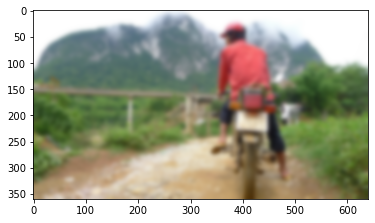

In [31]:
plt.imshow(lpf_(img,111))

In [34]:
imgs_list=[lpf_(img,i) for i in range(1,201,4)]


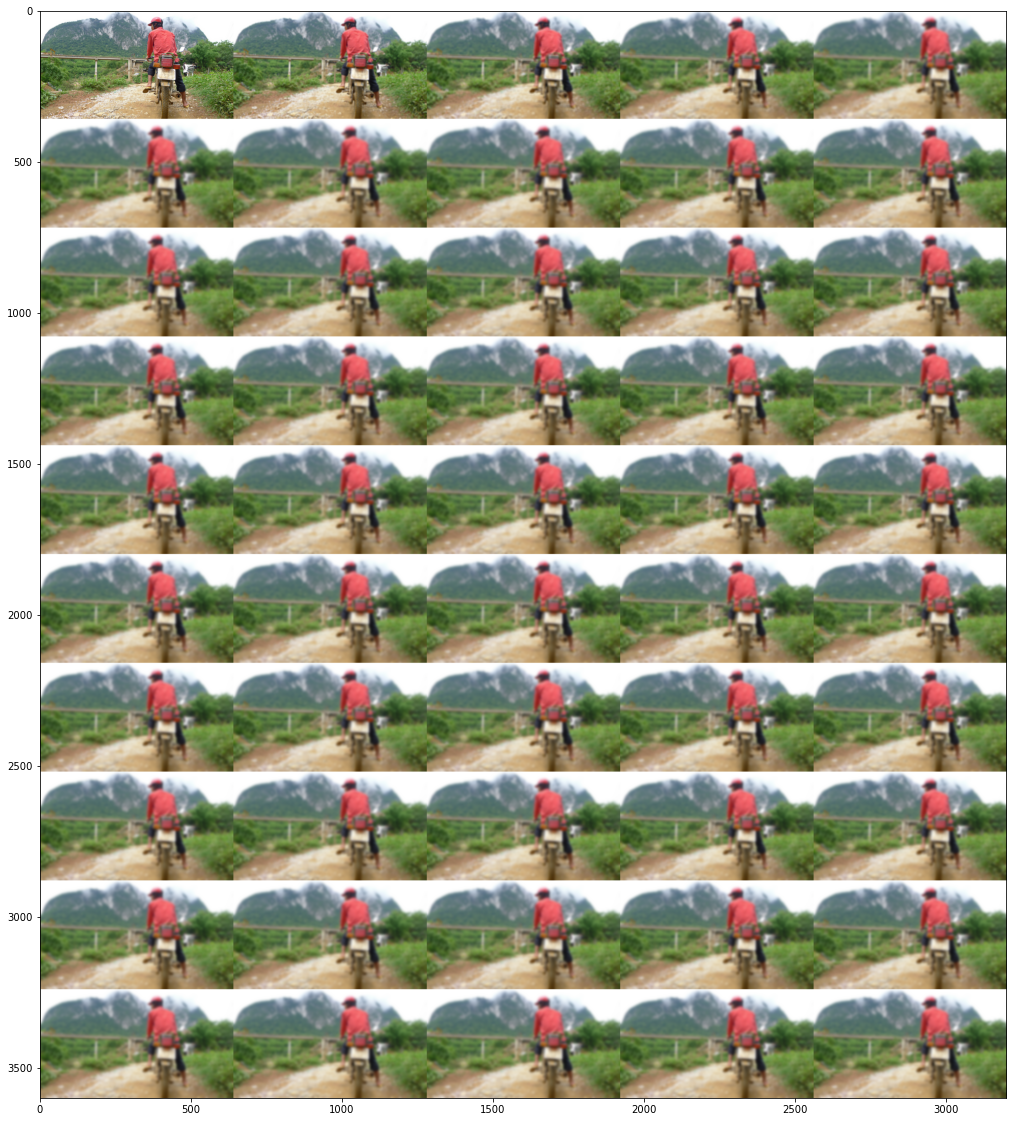

In [36]:
def image_grid(array, ncols=5):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, -1))
    
    return img_grid

result = image_grid(np.array(imgs_list))
fig = plt.figure(figsize=(20., 20.))
plt.imshow(result)

In [38]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [48]:
COCOD

TypeError: 'module' object is not callable

In [51]:
DS.coco(root=root_img_path,annFile=valid_set)

TypeError: 'module' object is not callable

In [ ]:
root_img_path="/Users/riiid/Documents/Dataset/coco/val2014/"
valid_set=COCO('/Users/riiid/Documents/Dataset/coco/annotations/instances_val2014.json')